In [0]:
import tensorflow as tf
import keras

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
dataset_path = '/content/drive/My Drive/Colab Notebooks/MER/model_trial/dataset/CADEC.csv'
dataset_path_twitter = '/content/drive/My Drive/Colab Notebooks/MER/model_trial/dataset/twitter_521.csv'
BATCH_SIZE = 512  # Number of examples used in each iteration
EPOCHS = 100 #Number of passes through entire dataset
MAX_LEN = 60  # Max length of review (in words)
EMBEDDING = 200# Dimension of word embedding vector

In [0]:
data_twitter = pd.read_csv(dataset_path_twitter, names=['Sentence No', 'Word', 'Tag'], header=0)
data = pd.read_csv(dataset_path)

# data


data = data.drop(['Document ID'], axis=1)

# Adding some of the twitter data in the cadec dataset to train better for the twitter data
data = data.append(data_twitter[0:5991], ignore_index=True)

# Remaining twitter data is for testing
data_twitter = data_twitter[5991:]
print(data_twitter.shape)

data = data.fillna(method="ffill")
data_twitter = data_twitter.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence No'])))
print("Number of sentences in twitter : ", len(data_twitter.groupby(['Sentence No'])))


words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)
words_twitter = list(set(data_twitter["Word"].values))
n_words_twitter = len(words_twitter)
print("Number of words in the dataset: ", n_words_twitter)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

# tags_twitter = list(set(data_twitter["Tag"].values))
# print("Tags:", tags_twitter)
# n_tags_twitter = len(tags_twitter)
# print("Number of Labels: ", n_tags_twitter)

print("What the dataset looks like:")
# Show the first 10 rows
data['Tag'].value_counts()


(6434, 3)
Number of sentences:  7771
Number of sentences in twitter :  271
Number of words in the dataset:  9113
Number of words in the dataset:  1971
Tags: ['B-ADR', 'B-Symptom', 'I-ADR', 'B-Finding', 'I-Symptom', 'I-Drug', 'B-Disease', 'I-Finding', 'I-Disease', 'O', 'B-Drug']
Number of Labels:  11
What the dataset looks like:


O            107139
I-ADR         10900
B-ADR          5756
B-Drug         2058
I-Symptom       482
I-Finding       477
B-Symptom       463
B-Finding       414
B-Disease       353
I-Drug          274
I-Disease       255
Name: Tag, dtype: int64

7771


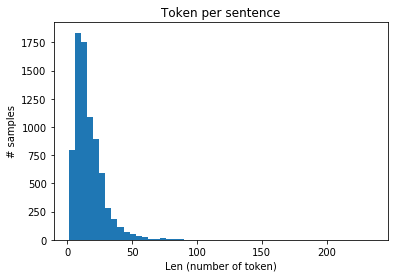

In [0]:
from random import shuffle
import random
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Tag_1), ..., (Token_n, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence No").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
getter_twitter = SentenceGetter(data_twitter)
sent = getter.get_next()# Get all the sentences
sentences = getter.sentences
sentences_twitter = getter_twitter.sentences


# print(sentences_twitter)
# Shuffling the cadec and twitter dataset for better training
sentences = random.sample(sentences, len(sentences))
print(len(sentences))

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [0]:

# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding
word2idx
word2idx_twitter = {w: i + 2 for i, w in enumerate(words_twitter)}
word2idx_twitter["UNK"] = 1 # Unknown words
word2idx_twitter["PAD"] = 0 # Padding
word2idx_twitter




# Vocabulary Key:token_index -> Value:word
idx2word_twitter = {i: w for w, i in word2idx_twitter.items()}
idx2word_twitter
idx2word = {i: w for w, i in word2idx.items()}
idx2word

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
tag2idx
# tag2idx_twitter = {t: i+1 for i, t in enumerate(tags_twitter)}
# tag2idx_twitter["PAD"] = 0
# tag2idx_twitter


# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}
idx2tag
# idx2tag_twitter = {i: w for w, i in tag2idx_twitter.items()}
# idx2tag_twitter


print("The word Drugs is identified by the index: {}".format(word2idx["Drug"]))
print("The labels B-Symptom(which defines Symptom related Enitities) is identified by the index: {}".format(tag2idx["B-Symptom"]))

from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])
X_twitter = [[word2idx_twitter[w[0]] for w in s] for s in sentences_twitter]
# Padding each sentence to have the same lenght
X_twitter = pad_sequences(maxlen=MAX_LEN, sequences=X_twitter, padding="post", value=word2idx_twitter["PAD"])


# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentences]
# Padding each sentence to have the same length
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)
y_twitter = [[tag2idx[w[1]] for w in s] for s in sentences_twitter]
# Padding each sentence to have the same length
y_twitter = pad_sequences(maxlen=MAX_LEN, sequences=y_twitter, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical
# One-Hot encode
y_twitter = [to_categorical(i, num_classes=n_tags+1) for i in y_twitter]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
# X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

X_tr, X_te = X, X_twitter
y_tr, y_te = y, y_twitter


X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape


print(" sentence is : ")
(print(idx2word_twitter[word]) for word in sentences_twitter)

print('Raw Sample: ', ' '.join([w[0] for w in sentences_twitter[0]]))
print('Raw Label: ', ' '.join([w[1] for w in sentences_twitter[0]]))

The word Drugs is identified by the index: 6064
The labels B-Symptom(which defines Symptom related Enitities) is identified by the index: 2
 sentence is : 
Raw Sample:  LabileStudy is a clinical trial of lamotrigine versus placebo for people with borderline personality disorder .
Raw Label:  O O O O O O B-Drug O O O O O O O O O


In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
input
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 60, 200)           1823000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 60, 100)           100400    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 60, 50)            5050      
_________________________________________________________________
crf_5 (CRF)                  (None, 60, 12)            780       
Total params: 1,929,230
Trainable params: 1,929,230
Non-trainable params: 0
_________________________________________________________________


In [0]:
# history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,validation_split=0.1, verbose=2)
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,validation_split=0.0, verbose=2)

# Eval
pred_cat = model.predict(X_te)
print(pred_cat.shape)
pred = np.argmax(pred_cat, axis=-1)
# print('pred : ',pred.shape)
y_te_true = np.argmax(y_te, -1)
# print('y_te_true : ',y_te_true.shape)






Epoch 1/100
 - 25s - loss: 13.6024 - crf_viterbi_accuracy: 0.6679
Epoch 2/100
 - 21s - loss: 12.8892 - crf_viterbi_accuracy: 0.8342
Epoch 3/100
 - 21s - loss: 12.7645 - crf_viterbi_accuracy: 0.8372
Epoch 4/100
 - 21s - loss: 12.6849 - crf_viterbi_accuracy: 0.8535
Epoch 5/100
 - 21s - loss: 12.6231 - crf_viterbi_accuracy: 0.8695
Epoch 6/100
 - 21s - loss: 12.5759 - crf_viterbi_accuracy: 0.8902
Epoch 7/100
 - 21s - loss: 12.5416 - crf_viterbi_accuracy: 0.9036
Epoch 8/100
 - 21s - loss: 12.5159 - crf_viterbi_accuracy: 0.9112
Epoch 9/100
 - 22s - loss: 12.4958 - crf_viterbi_accuracy: 0.9155
Epoch 10/100
 - 21s - loss: 12.4800 - crf_viterbi_accuracy: 0.9196
Epoch 11/100
 - 21s - loss: 12.4666 - crf_viterbi_accuracy: 0.9241
Epoch 12/100
 - 21s - loss: 12.4518 - crf_viterbi_accuracy: 0.9265
Epoch 13/100
 - 21s - loss: 12.4421 - crf_viterbi_accuracy: 0.9288
Epoch 14/100
 - 21s - loss: 12.4304 - crf_viterbi_accuracy: 0.9317
Epoch 15/100
 - 21s - loss: 12.4214 - crf_viterbi_accuracy: 0.9345
Epoc

In [0]:
pred.shape
from sklearn_crfsuite.metrics import flat_classification_report
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 


In [0]:
print(" final pred_tag : ",len(pred_tag))

 final pred_tag :  271


In [0]:
print(len(pred_tag))
print(len(y_te_true_tag))
print("===========================")
tp = 0
total = 0

for i in range(0,len(pred_tag)):
    for j in range(0,len(pred_tag[0])):
#       print(y_te_true_tag[i][j],pred_tag[i][j])
      if y_te_true_tag[i][j] == pred_tag[i][j]:
        tp += 1
      total += 1
        


print("===========================")
print(" Accuracy : ",float(tp)/total," % ")
# from seqeval.metrics import classification_report
report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

271
271
 Accuracy :  0.8793972939729398  % 
              precision    recall  f1-score   support

       B-ADR       0.00      0.00      0.00         0
   B-Disease       0.00      0.00      0.00        52
      B-Drug       0.03      0.02      0.02       309
   B-Finding       0.00      0.00      0.00         0
   B-Symptom       0.25      0.00      0.01       231
       I-ADR       0.00      0.00      0.00         0
   I-Disease       0.00      0.00      0.00        38
      I-Drug       0.00      0.00      0.00        32
   I-Finding       0.00      0.00      0.00         0
   I-Symptom       0.15      0.01      0.02       190
           O       0.87      0.80      0.83      5582
         PAD       1.00      1.00      1.00      9826

    accuracy                           0.88     16260
   macro avg       0.19      0.15      0.16     16260
weighted avg       0.91      0.88      0.89     16260



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [0]:
!pip install tensorflow

In [0]:
!pip install keras==2.2.4

In [0]:
!pip install sklearn-crfsuite